In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

Satelli sampling means variance based sampling, but not a good measure for non-uniform distribution. Advantage: just extends series further if you want to increase number of samples
Parallelization of sampling --> batch run (concurrent)

# Added modules

In [2]:
def get_theta(x, mu, sigma):
    """
    x: fraction of similar neighbours
    mu: optimal fraction of similar neighbours
    sigma: acceptance range
    """
    theta = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    return theta

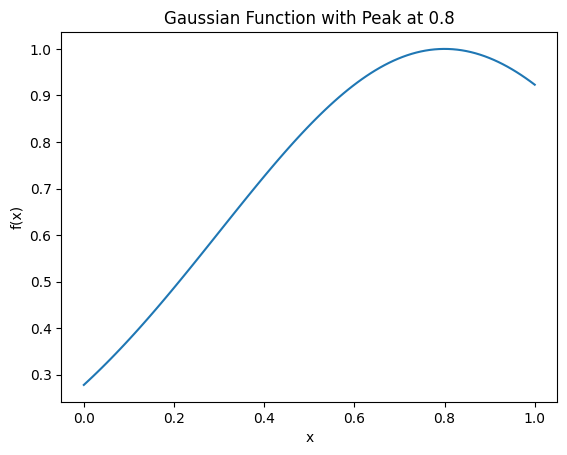

In [27]:
def gaussian_function(x, mu, sigma):
    return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# Example usage:
x_values = np.linspace(0, 1, 100)
mu = 0.8  # Peak in the middle
sigma = 0.5  # Controls the width

y_values = gaussian_function(x_values, mu, sigma)

# You can plot the function to visualize it
import matplotlib.pyplot as plt

plt.plot(x_values, y_values)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(f'Gaussian Function with Peak at {mu}')
plt.show()

# Sobol Sensitivity Analysis

In [4]:
from SALib.sample import saltelli
from SALib.analyze import sobol

In [22]:
import modules as modules
import model as model
from model import Schelling

def schelling_SA(num_runs, num_steps, burn_in_period, minority_pc, property_value_weight, alpha, mu_theta, sigma_theta, density):

    # initialize storage for parameters
    overall_desirability_entropy = []
    overall_agent_entropy = []
    overall_utility = []

    # run the model several times for the same parameter setting 
    for _ in range(num_runs):

        # initialize model
        models = Schelling(
            property_value_func=modules.property_value_quadrants,
            income_func=modules.income_func,
            desirability_func=modules.desirability_func,
            utility_func=modules.utility_func,
            price_func=modules.price_func,
            compute_similar_neighbours=modules.compute_similar_neighbours,
            calculate_gi_star = modules.calculate_gi_star,
            update_interested_agents_func = modules.update_interested_agents_concurrently,
            price_func_cap=modules.price_func_cap,
            height=20,
            width=20,
            radius=1,
            density=density,
            minority_pc=minority_pc,
            alpha=alpha,
            income_scale=1.5, # the scale by which the income is higher than the property value
            property_value_weight=property_value_weight,
            mu_theta = mu_theta,
            sigma_theta = sigma_theta,
            seed=42)

        # Run the model for a certain number of steps
        for _ in range(num_steps):
            models.step()

        # call necessary data collectors
        agent_data = models.datacollector.get_agent_vars_dataframe()
        model_data_entropy = models.datacollector.get_model_vars_dataframe()
    
        # Compute mean and standard deviation of entropies over time per run
        desirability_entropy = model_data_entropy['Desirability entropy'].to_numpy()
        # desirability_entropy_std = model_data_entropy['Desirability entropy'].std()
        mean_desirability_entropy = np.mean(desirability_entropy[burn_in_period::])
    
        agent_entropy = model_data_entropy['Agent entropy'].to_numpy()
        # agent_entropy_std = model_data_entropy['Agent entropy'].std()
        mean_agent_entropy = np.mean(agent_entropy[burn_in_period::])
        
        # Compute mean and standard deviation of utility per time step over each agent 
        utility_mean = agent_data.groupby(level='Step')['Utility'].mean()
        #utility_std = agent_data.groupby(level='Step')['Utility'].std()
    
        # Compute mean and standard deviation of utility over time 
        utility_mean = pd.DataFrame(utility_mean).to_numpy()
        #utility_std = pd.DataFrame(utility_std).to_numpy()
        mean_utility_interim = np.mean(utility_mean[burn_in_period::])

        # Append all results to storage
        overall_desirability_entropy.append(mean_desirability_entropy)
        overall_agent_entropy.append(mean_agent_entropy)
        overall_utility.append(mean_utility_interim)

    mean_desirability = np.mean(overall_desirability_entropy)
    mean_agent = np.mean(overall_agent_entropy)
    mean_utility = np.mean(overall_utility)

    return mean_desirability, mean_agent, mean_utility

In [23]:
a, b, c, d, e, f = [0.09375, 0.46875, 0.46875, 0.65625, 0.28125, 0.96875]
x = schelling_SA(2, 5, 2, a, b, c, d, e, f)

['Updating Desirability: 0.57s', 'Updating Entropies: 0.00s', 'Agent Step: 0.03s', 'Data Collection: 0.00s']
['Updating Desirability: 0.46s', 'Updating Entropies: 0.00s', 'Agent Step: 0.03s', 'Data Collection: 0.00s']
['Updating Desirability: 0.43s', 'Updating Entropies: 0.00s', 'Agent Step: 0.03s', 'Data Collection: 0.00s']
['Updating Desirability: 0.41s', 'Updating Entropies: 0.00s', 'Agent Step: 0.03s', 'Data Collection: 0.00s']
['Updating Desirability: 0.40s', 'Updating Entropies: 0.00s', 'Agent Step: 0.03s', 'Data Collection: 0.00s']
['Updating Desirability: 0.56s', 'Updating Entropies: 0.00s', 'Agent Step: 0.03s', 'Data Collection: 0.00s']
['Updating Desirability: 0.47s', 'Updating Entropies: 0.00s', 'Agent Step: 0.03s', 'Data Collection: 0.00s']
['Updating Desirability: 0.43s', 'Updating Entropies: 0.00s', 'Agent Step: 0.03s', 'Data Collection: 0.00s']
['Updating Desirability: 0.41s', 'Updating Entropies: 0.00s', 'Agent Step: 0.03s', 'Data Collection: 0.00s']
['Updating Desirabi

In [9]:
# Step 1: Problem definition
problem = {
    'num_vars': 6,
    'names': ['density', 'minority_pc', 'property_value_weight', 'alpha', 'mu_theta', 'sigma_theta'],
    'bounds': [[0,1], [0,1], [0,1], [0,1], [0,1], [0,1]]
}

# Step 2: Generate samples 
samples = saltelli.sample(problem, 1) #2**5) #2024

In [10]:
# Step 3: evaluate the model under the different parameter settings 
# Define settings 
iterations = 1
model_steps = 4
burn_in = 2

# Initialize storage for measures
result_desirability = np.zeros([samples.shape[0]])
result_agent = np.zeros([samples.shape[0]])
result_utility = np.zeros([samples.shape[0]])

for i, X in enumerate(samples):
    result_desirability[i] = schelling_SA(iterations, model_steps, burn_in, *X)[0]
    result_agent[i] = schelling_SA(iterations, model_steps, burn_in, *X)[1]
    result_utility[i] = schelling_SA(iterations, model_steps, burn_in, *X)[2]

['Updating Desirability: 0.59s', 'Updating Entropies: 0.00s', 'Agent Step: 0.03s', 'Data Collection: 0.00s']
['Updating Desirability: 0.48s', 'Updating Entropies: 0.00s', 'Agent Step: 0.03s', 'Data Collection: 0.00s']
['Updating Desirability: 0.44s', 'Updating Entropies: 0.00s', 'Agent Step: 0.03s', 'Data Collection: 0.00s']
['Updating Desirability: 0.42s', 'Updating Entropies: 0.00s', 'Agent Step: 0.03s', 'Data Collection: 0.00s']
['Updating Desirability: 0.56s', 'Updating Entropies: 0.00s', 'Agent Step: 0.03s', 'Data Collection: 0.00s']
['Updating Desirability: 0.46s', 'Updating Entropies: 0.00s', 'Agent Step: 0.03s', 'Data Collection: 0.00s']
['Updating Desirability: 0.43s', 'Updating Entropies: 0.00s', 'Agent Step: 0.03s', 'Data Collection: 0.00s']
['Updating Desirability: 0.42s', 'Updating Entropies: 0.00s', 'Agent Step: 0.03s', 'Data Collection: 0.00s']
['Updating Desirability: 0.56s', 'Updating Entropies: 0.00s', 'Agent Step: 0.03s', 'Data Collection: 0.00s']
['Updating Desirabi

In [11]:
# Step 4: analyse results
Si_desirability = sobol.analyze(problem, result_desirability, print_to_console=True)

                              ST       ST_conf
density                42.406884  4.198962e-14
minority_pc             0.031894  1.366850e-17
property_value_weight   0.102499  5.467399e-17
alpha                   9.256151  3.499135e-15
mu_theta                4.698075  0.000000e+00
sigma_theta             2.073115  1.749568e-15
                              S1       S1_conf
density               -28.871072  6.998270e-15
minority_pc            -0.791769  4.373919e-16
property_value_weight  -1.419399  4.373919e-16
alpha                 -13.488384  1.049741e-14
mu_theta               -9.609586  6.998270e-15
sigma_theta             6.383465  3.499135e-15
                                             S2       S2_conf
(density, minority_pc)                27.415450  1.399654e-14
(density, property_value_weight)      27.745718  1.399654e-14
(density, alpha)                      34.096589  0.000000e+00
(density, mu_theta)                   32.055511  1.399654e-14
(density, sigma_theta)          

In [12]:
Si_agent = sobol.analyze(problem, result_agent, print_to_console=True)

                             ST       ST_conf
density                0.572128  4.373919e-16
minority_pc            0.004139  1.708562e-18
property_value_weight  0.001205  4.271405e-19
alpha                  0.003137  8.542810e-19
mu_theta               0.000359  0.000000e+00
sigma_theta            1.476831  0.000000e+00
                             S1       S1_conf
density               -1.833779  0.000000e+00
minority_pc            0.155968  1.093480e-16
property_value_weight  0.084150  2.733699e-17
alpha                  0.135789  5.467399e-17
mu_theta               0.045951  2.733699e-17
sigma_theta           -2.946223  0.000000e+00
                                            S2       S2_conf
(density, minority_pc)                2.488515  8.747838e-16
(density, property_value_weight)      2.629376  0.000000e+00
(density, alpha)                      2.528093  8.747838e-16
(density, mu_theta)                   2.704298  0.000000e+00
(density, sigma_theta)                8.573042  3.4

In [13]:
Si_utility = sobol.analyze(problem, result_utility, print_to_console=True)

                              ST       ST_conf
density                 0.929599  8.747838e-16
minority_pc             1.251517  4.373919e-16
property_value_weight   0.477396  0.000000e+00
alpha                  13.254613  1.049741e-14
mu_theta               14.878270  6.998270e-15
sigma_theta             1.357119  1.312176e-15
                             S1       S1_conf
density                2.430990  1.749568e-15
minority_pc            2.820679  0.000000e+00
property_value_weight  1.742107  8.747838e-16
alpha                 -9.179498  0.000000e+00
mu_theta              -9.725494  3.499135e-15
sigma_theta            2.937274  8.747838e-16
                                             S2       S2_conf
(density, minority_pc)               -12.373219  0.000000e+00
(density, property_value_weight)      -7.966765  3.499135e-15
(density, alpha)                      36.652913  0.000000e+00
(density, mu_theta)                   38.883549  1.399654e-14
(density, sigma_theta)               -1

In [14]:
# Step 5: Plots
# Set params generally for all plots
params = ['Density', 'Minority Percentage', 'Weight: property value', r"$\alpha$", r"$\mu$", r"$\sigma$"]

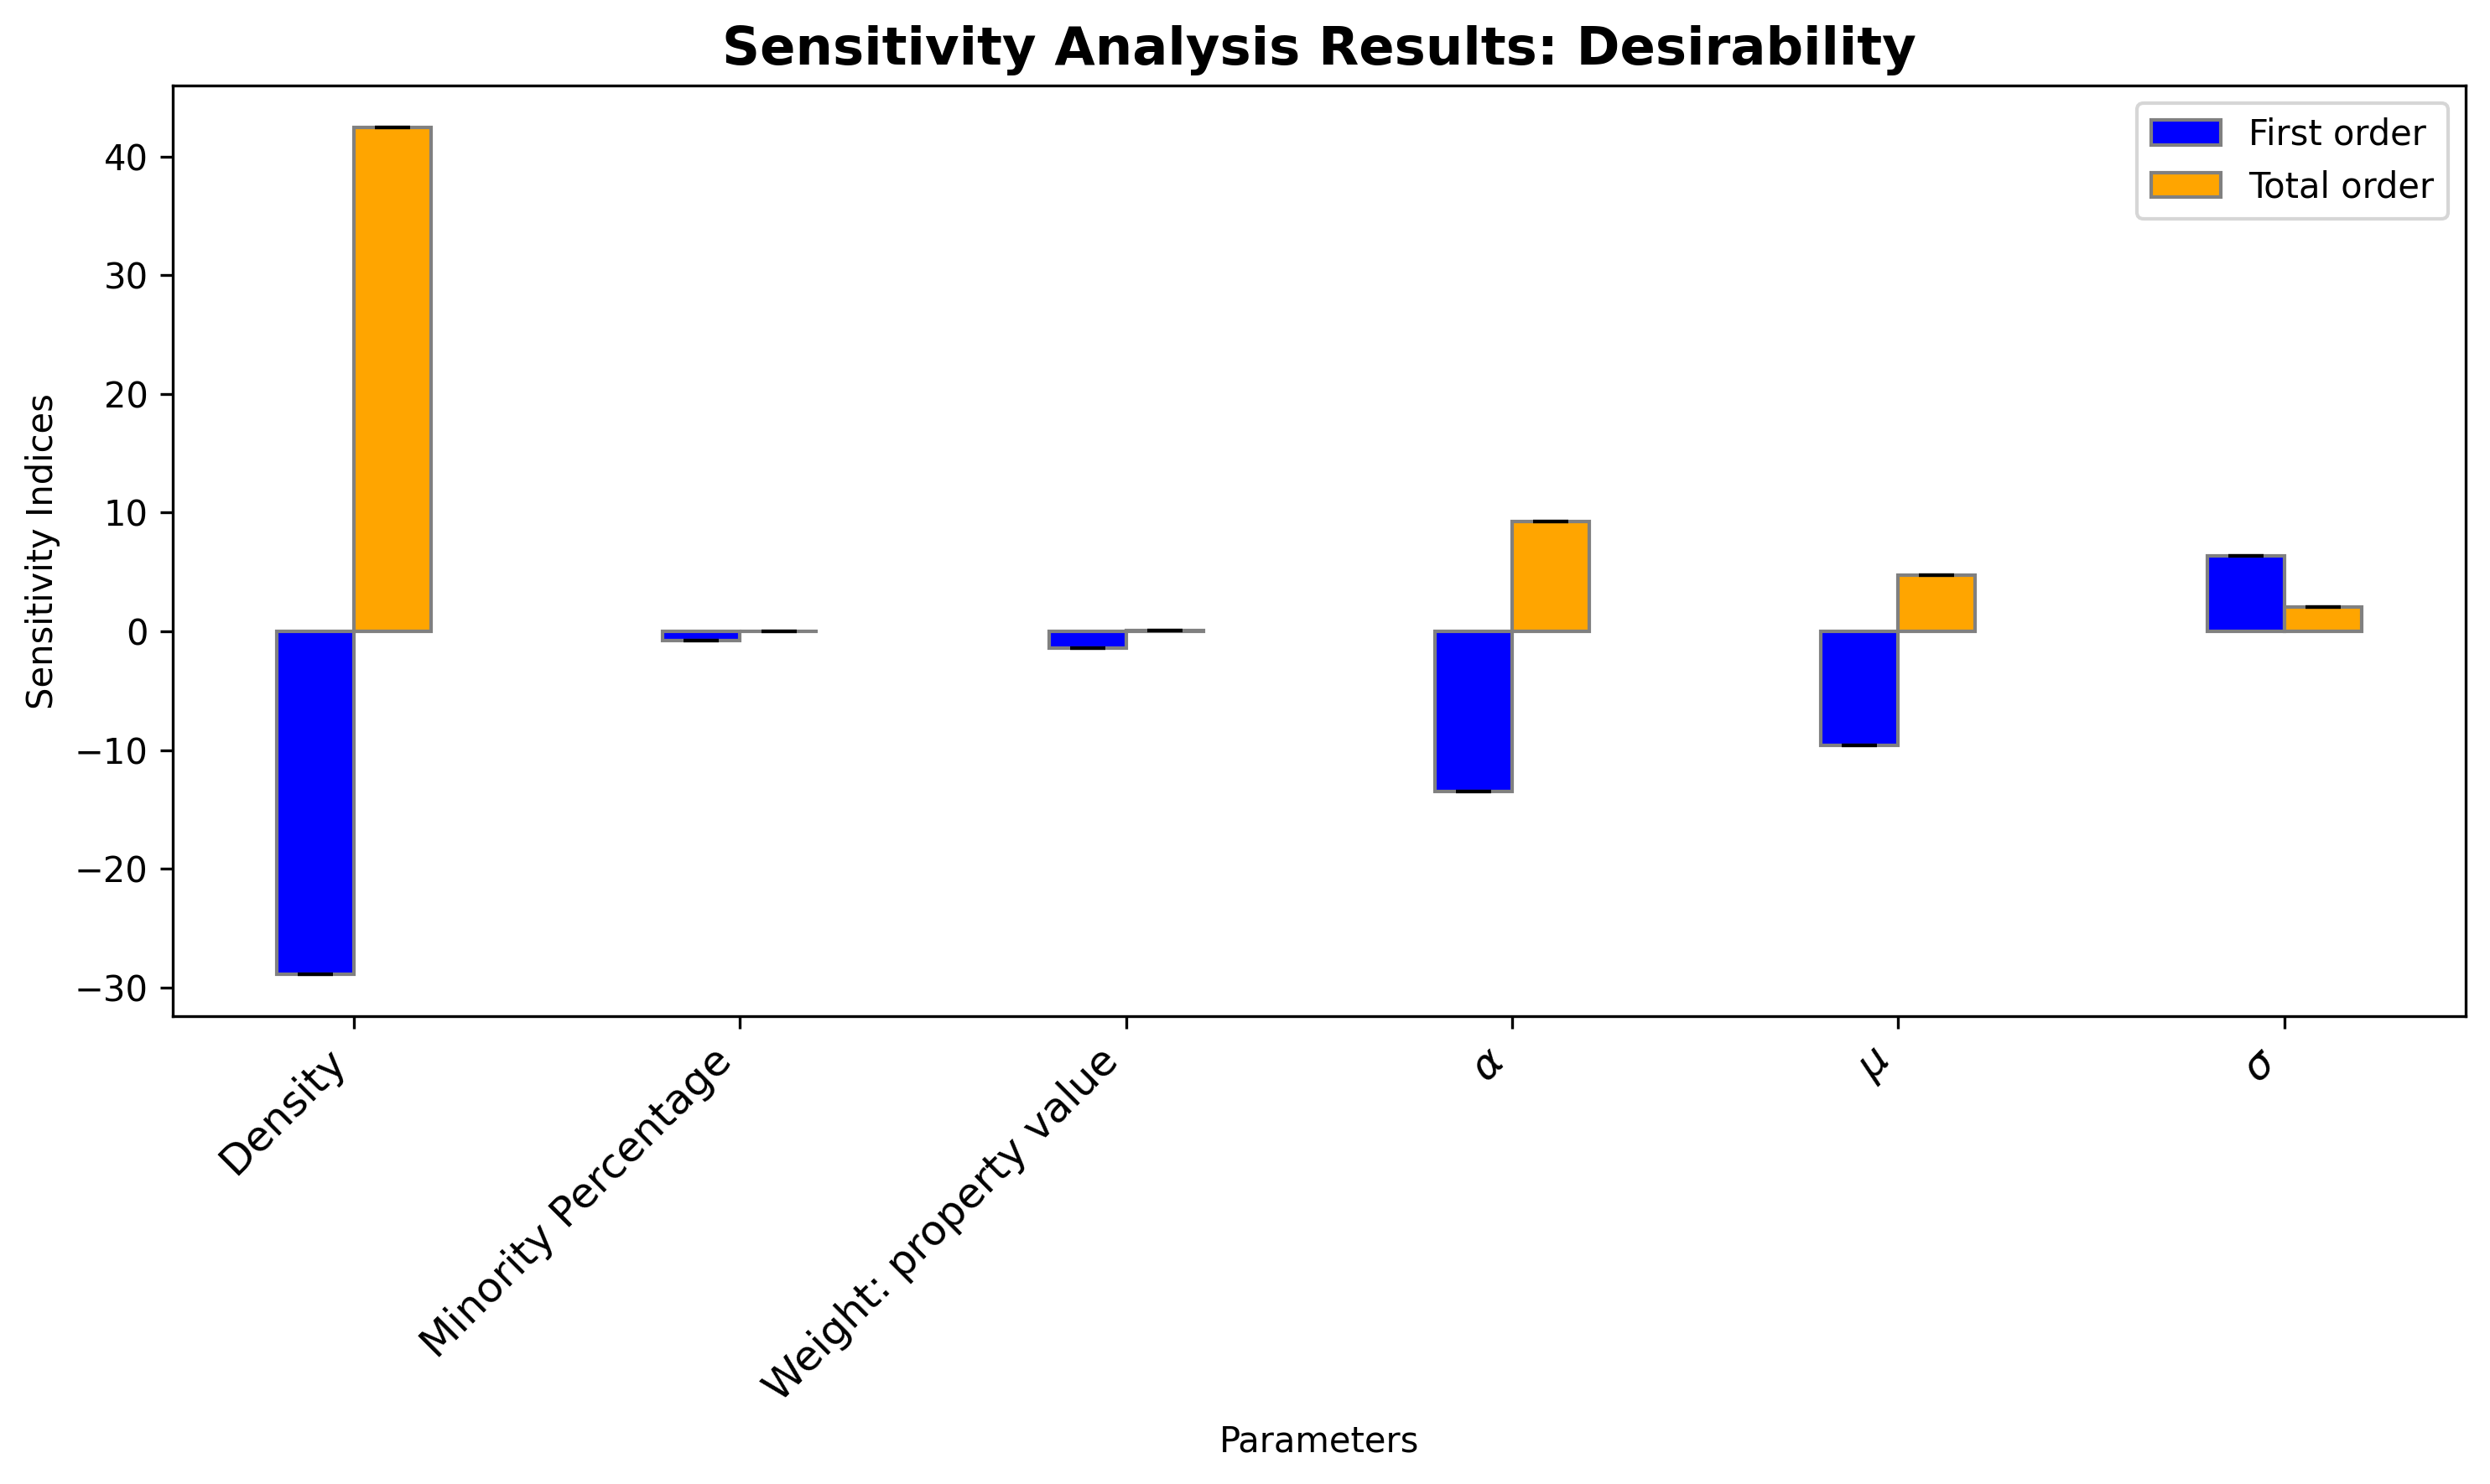

In [15]:
# Generate plot for desirability entropy
S1_desirability = Si_desirability['S1']
S1_conf_desirability = Si_desirability['S1_conf']

ST_desirability = Si_desirability['ST']
ST_conf_desirability = Si_desirability['ST_conf']

# Convert confidence intervals to errors (assuming symmetrical errors)
S1_err = np.array(S1_conf_desirability)
ST_err = np.array(ST_conf_desirability)

# Bar width
bar_width = 0.2

# Positions of the bars
r1 = np.arange(len(params))
r2 = [x + bar_width for x in r1]

# Create the figure and axis
fig, ax = plt.subplots(dpi = 300, figsize=(10, 6))

# Plot S1 and ST with error bars
bars1 = ax.bar(r1, S1_desirability, yerr=S1_err, capsize=5, color='blue', width=bar_width, edgecolor='grey', label='First order')
bars2 = ax.bar(r2, ST_desirability, yerr=ST_err, capsize=5, color='orange', width=bar_width, edgecolor='grey', label='Total order')

# Adding labels
ax.set_xlabel('Parameters', fontsize=10)
ax.set_ylabel('Sensitivity Indices', fontsize=10)
ax.set_title('Sensitivity Analysis Results: Desirability', fontweight='bold', fontsize=15)
ax.set_xticks([r + bar_width/2 for r in range(len(params))])
ax.set_xticklabels(params, rotation=45, ha='right', fontsize = 12)

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
plt.close()

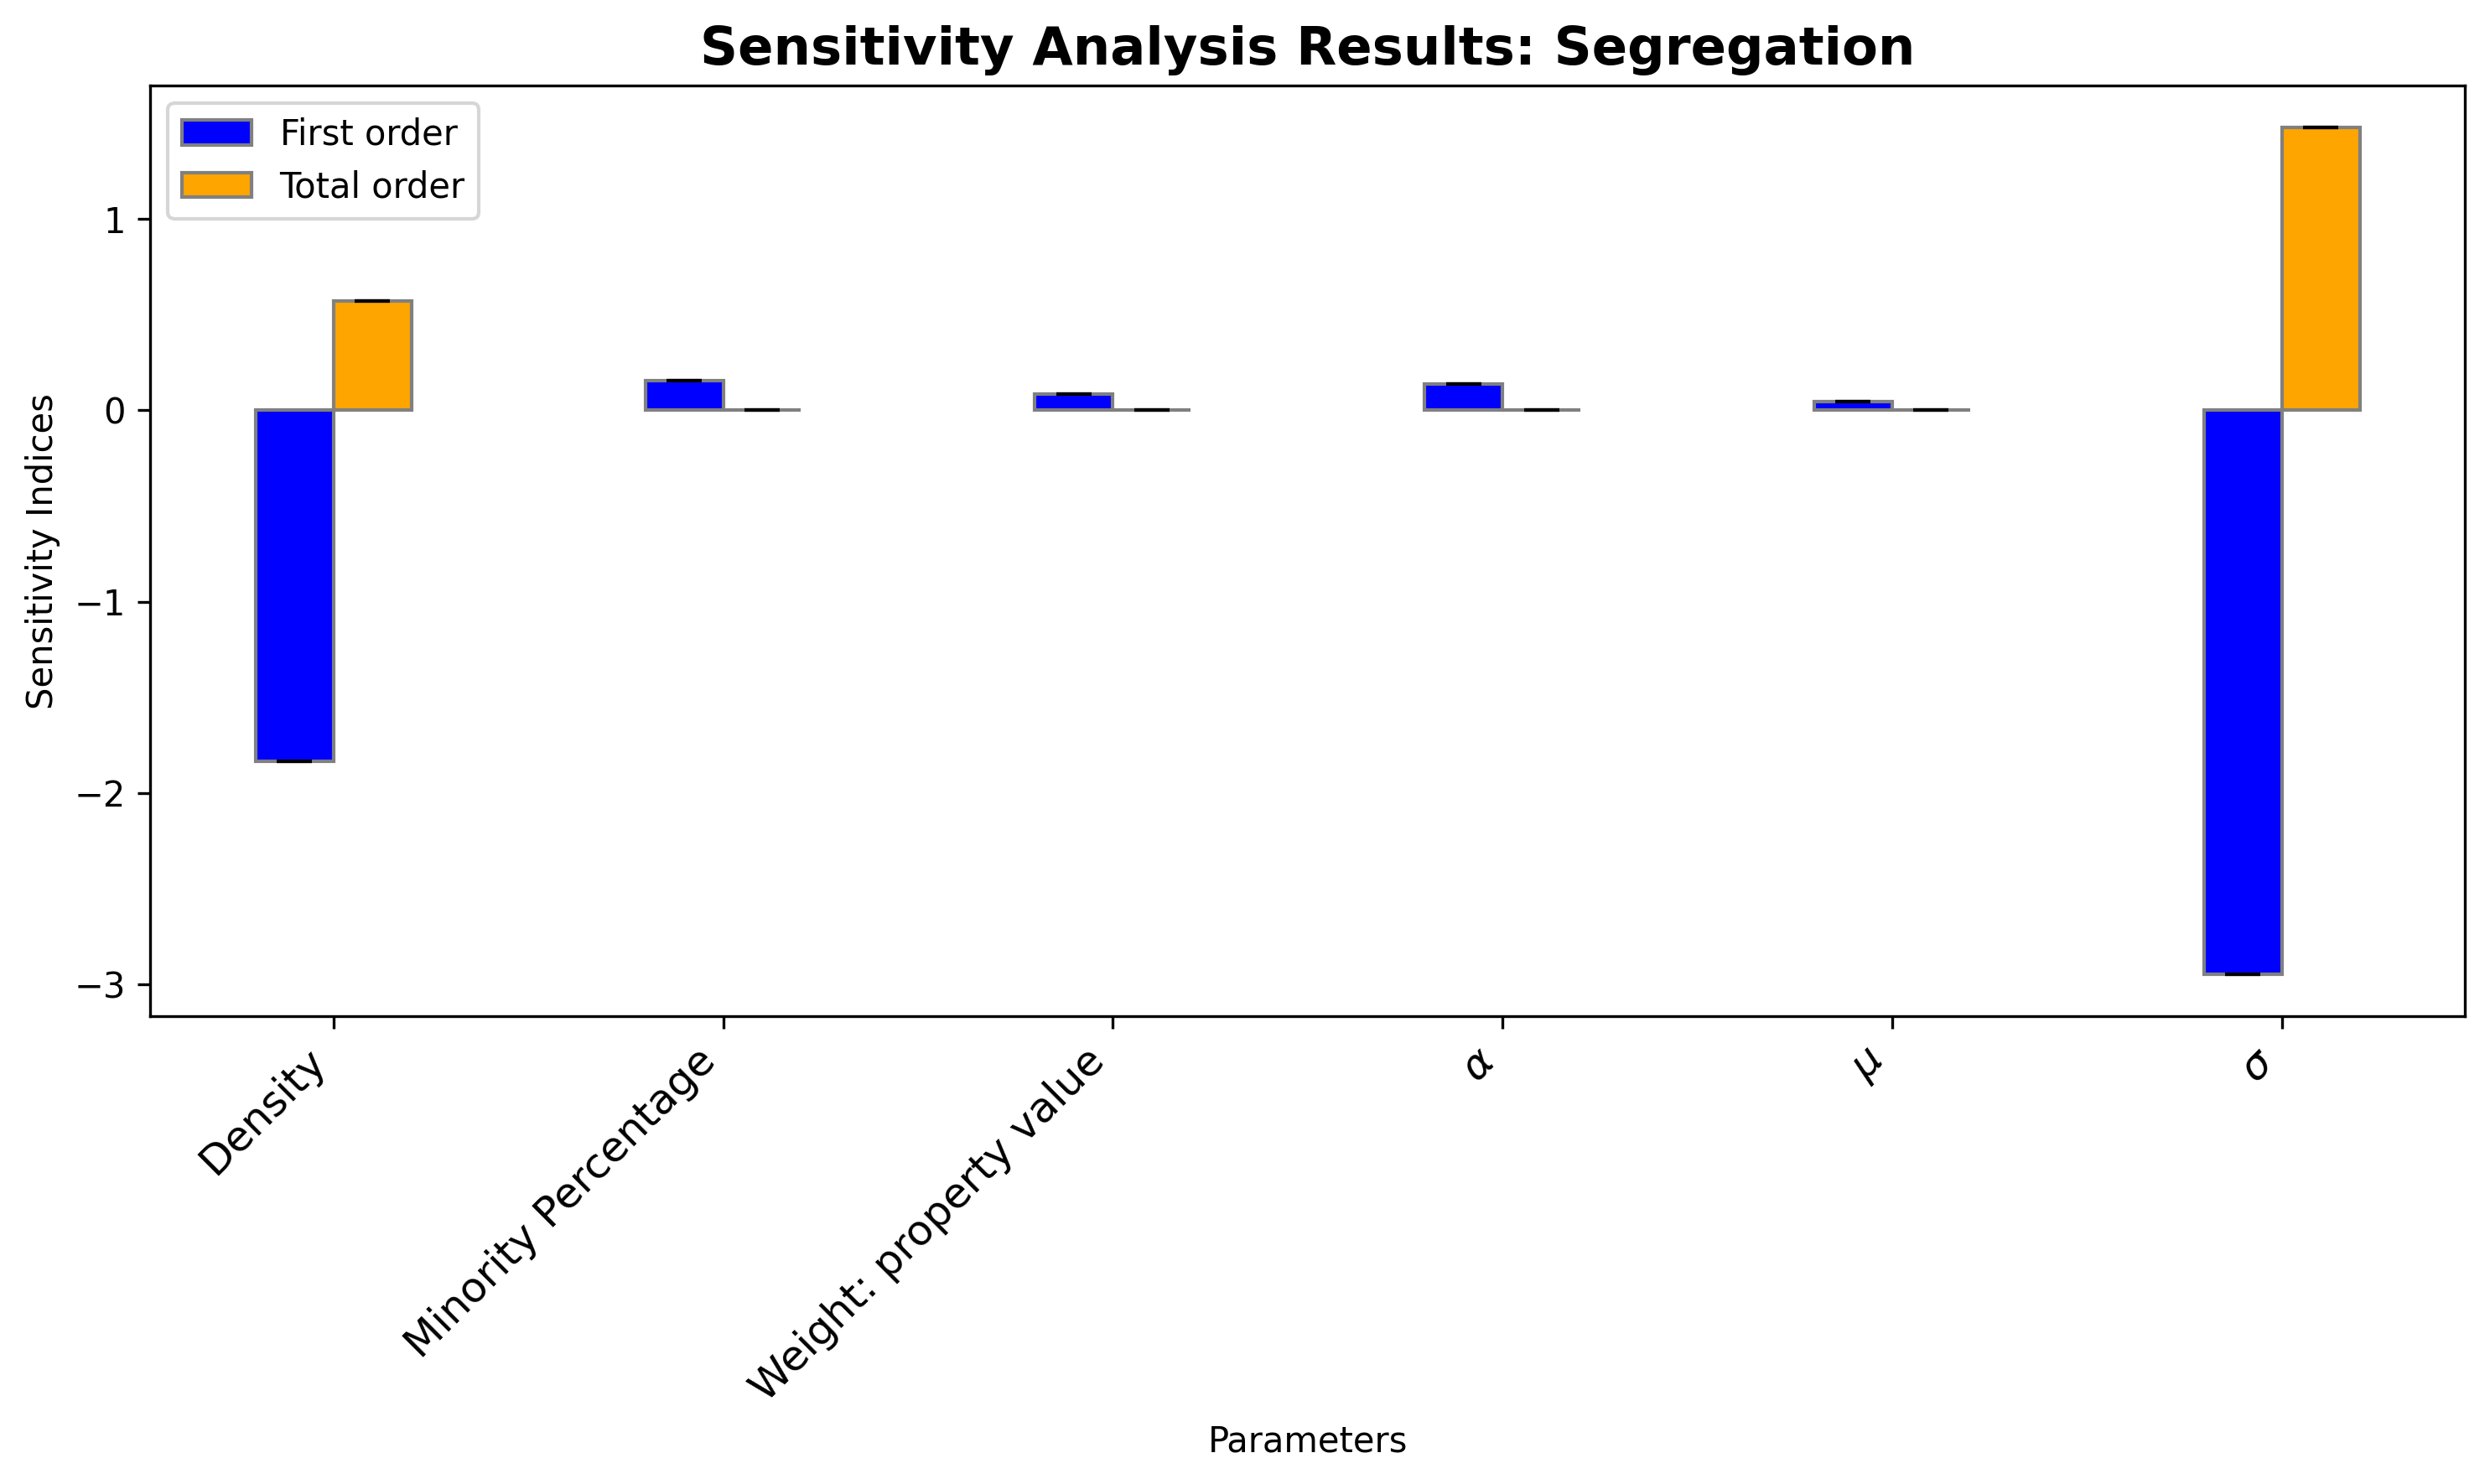

In [16]:
# Generate plot for desirability entropy
S1_agent = Si_agent['S1']
S1_conf_agent = Si_agent['S1_conf']

ST_agent = Si_agent['ST']
ST_conf_agent = Si_agent['ST_conf']

# Convert confidence intervals to errors (assuming symmetrical errors)
S1_err = np.array(S1_conf_agent)
ST_err = np.array(ST_conf_agent)

# Bar width
bar_width = 0.2

# Positions of the bars
r1 = np.arange(len(params))
r2 = [x + bar_width for x in r1]

# Create the figure and axis
fig, ax = plt.subplots(dpi = 300, figsize=(10, 6))

# Plot S1 and ST with error bars
bars1 = ax.bar(r1, S1_agent, yerr=S1_err, capsize=5, color='blue', width=bar_width, edgecolor='grey', label='First order')
bars2 = ax.bar(r2, ST_agent, yerr=ST_err, capsize=5, color='orange', width=bar_width, edgecolor='grey', label='Total order')

# Adding labels
ax.set_xlabel('Parameters', fontsize=10)
ax.set_ylabel('Sensitivity Indices', fontsize=10)
ax.set_title('Sensitivity Analysis Results: Segregation', fontweight='bold', fontsize=15)
ax.set_xticks([r + bar_width/2 for r in range(len(params))])
ax.set_xticklabels(params, rotation=45, ha='right', fontsize = 12)

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
plt.close()

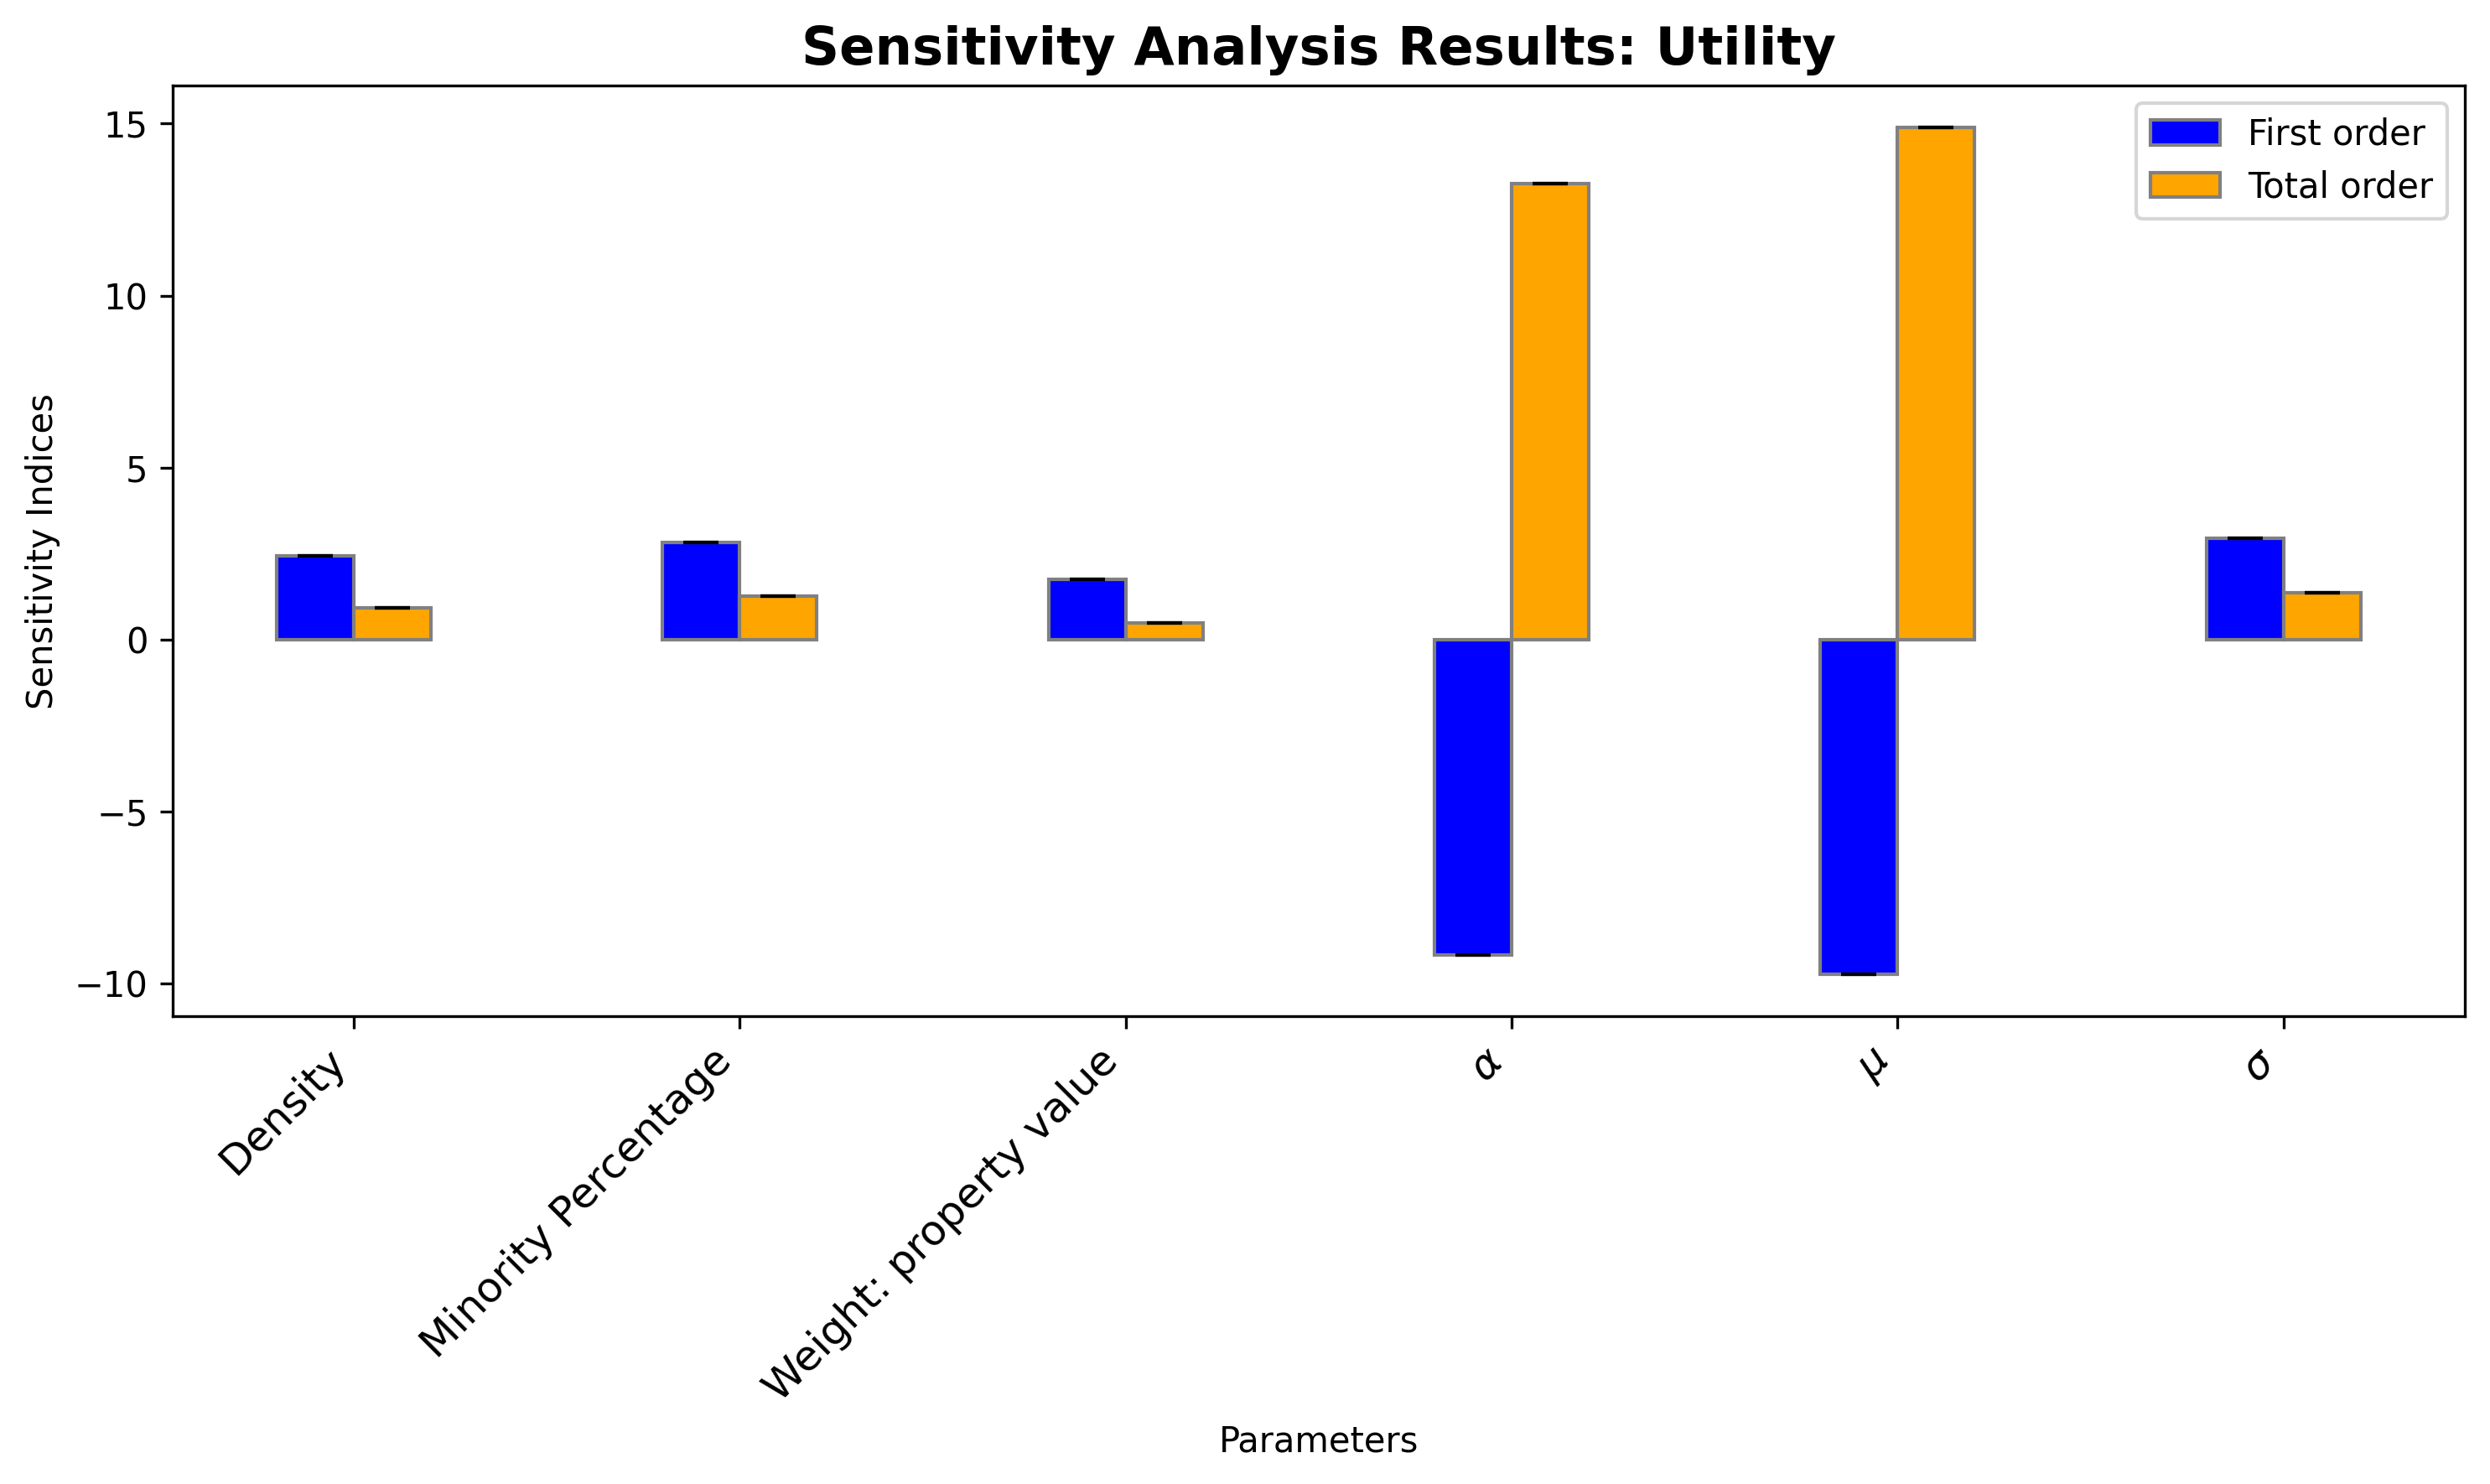

In [17]:
# Generate plot for desirability entropy
S1_utility = Si_utility['S1']
S1_conf_utility = Si_utility['S1_conf']

ST_utility = Si_utility['ST']
ST_conf_utility = Si_utility['ST_conf']

# Convert confidence intervals to errors (assuming symmetrical errors)
S1_err = np.array(S1_conf_utility)
ST_err = np.array(ST_conf_utility)

# Bar width
bar_width = 0.2

# Positions of the bars
r1 = np.arange(len(params))
r2 = [x + bar_width for x in r1]

# Create the figure and axis
fig, ax = plt.subplots(dpi = 300, figsize=(10, 6))

# Plot S1 and ST with error bars
bars1 = ax.bar(r1, S1_utility, yerr=S1_err, capsize=5, color='blue', width=bar_width, edgecolor='grey', label='First order')
bars2 = ax.bar(r2, ST_utility, yerr=ST_err, capsize=5, color='orange', width=bar_width, edgecolor='grey', label='Total order')

# Adding labels
ax.set_xlabel('Parameters', fontsize=10)
ax.set_ylabel('Sensitivity Indices', fontsize=10)
ax.set_title('Sensitivity Analysis Results: Utility', fontweight='bold', fontsize=15)
ax.set_xticks([r + bar_width/2 for r in range(len(params))])
ax.set_xticklabels(params, rotation=45, ha='right', fontsize = 12)

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
plt.close()

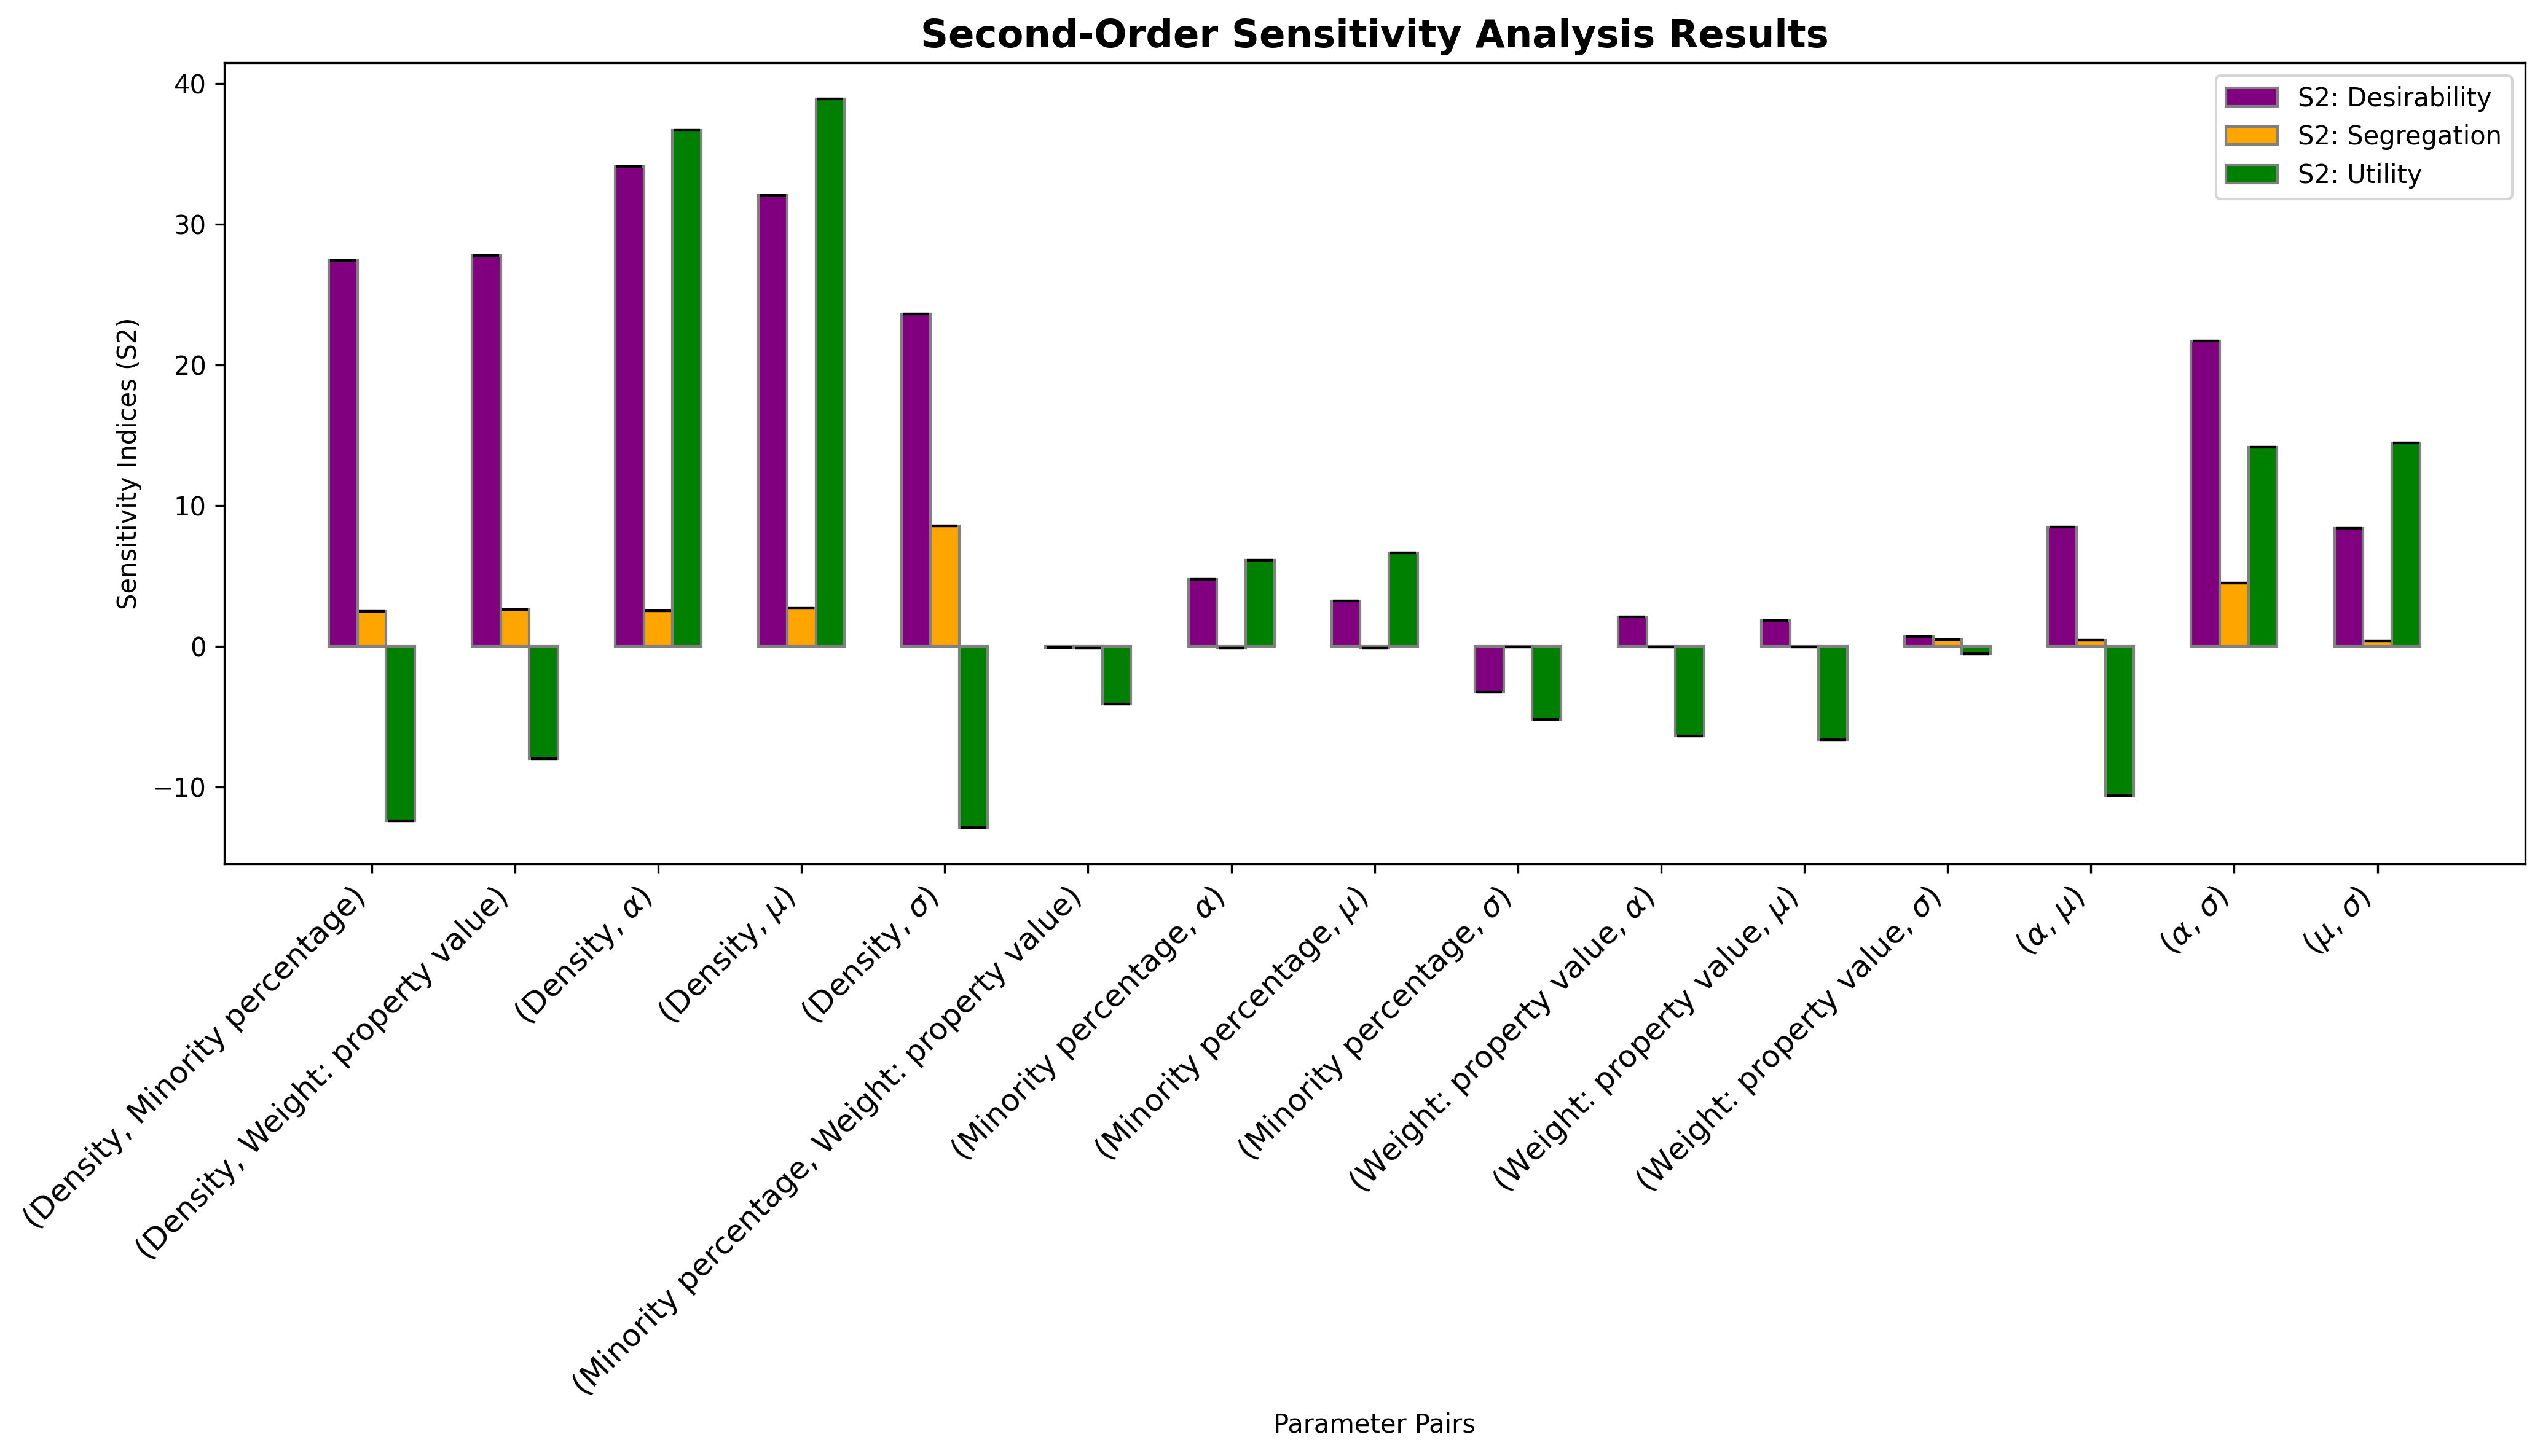

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Sensitivity analysis results
pairs = [
    '(Density, Minority percentage)', 
    '(Density, Weight: property value)', 
    r'(Density, $\alpha$)', 
    r'(Density, $\mu$)', 
    r'(Density, $\sigma$)', 
    '(Minority percentage, Weight: property value)', 
    r'(Minority percentage, $\alpha$)', 
    r'(Minority percentage, $\mu$)', 
    r'(Minority percentage, $\sigma$)', 
    r'(Weight: property value, $\alpha$)', 
    r'(Weight: property value, $\mu$)', 
    r'(Weight: property value, $\sigma$)', 
    r'($\alpha$, $\mu$)', 
    r'($\alpha$, $\sigma$)', 
    r'($\mu$, $\sigma$)'
]
# Three sets of S2 values and their confidence intervals
S2_desirability = np.array(Si_desirability['S2'])
S2_desirability = S2_desirability[~np.isnan(S2_desirability)]
S2_conf_desirability = np.array(Si_desirability['S2_conf'])
S2_conf_desirability = S2_conf_desirability[~np.isnan(S2_conf_desirability)]

S2_agent = np.array(Si_agent['S2'])
S2_agent = S2_agent[~np.isnan(S2_agent)]
S2_conf_agent = np.array(Si_agent['S2_conf'])
S2_conf_agent = S2_conf_agent[~np.isnan(S2_conf_agent)]

S2_utility = np.array(Si_utility['S2'])
S2_utility = S2_utility[~np.isnan(S2_utility)]
S2_conf_utility = np.array(Si_utility['S2_conf'])
S2_conf_utility = S2_conf_utility[~np.isnan(S2_conf_utility)]

# Convert confidence intervals to errors (assuming symmetrical errors)
S2_1_err = np.array(S2_conf_desirability)
S2_2_err = np.array(S2_conf_agent)
S2_3_err = np.array(S2_conf_utility)

# Ensure all arrays are of the same length
assert len(pairs) == len(S2_desirability) == len(S2_conf_desirability) == len(S2_agent) == len(S2_conf_agent) == len(S2_utility) == len(S2_conf_utility), "All input arrays must have the same length"

# Bar width
bar_width = 0.2

# Positions of the bars
positions = np.arange(len(pairs))
r1 = positions - bar_width
r2 = positions
r3 = positions + bar_width


# Create the figure and axis
fig, ax = plt.subplots(dpi = 300, figsize=(14, 8))

# Plot with error bars
bars1 = ax.bar(r1, S2_desirability, yerr=S2_1_err, capsize=5, color='purple', width=bar_width, edgecolor='grey', label='S2: Desirability')
bars2 = ax.bar(r2, S2_agent, yerr=S2_2_err, capsize=5, color='orange', width=bar_width, edgecolor='grey', label='S2: Segregation')
bars3 = ax.bar(r3, S2_utility, yerr=S2_3_err, capsize=5, color='green', width=bar_width, edgecolor='grey', label='S2: Utility')

# Adding labels
ax.set_xlabel('Parameter Pairs', fontsize=10)
ax.set_ylabel('Sensitivity Indices (S2)', fontsize=10)
ax.set_title('Second-Order Sensitivity Analysis Results', fontweight='bold', fontsize=15)
ax.set_xticks(positions)
ax.set_xticklabels(pairs, rotation=45, ha='right', fontsize=12)

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
plt.close()